# 1.Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory
from sklearn.decomposition import PCA
import numpy as np
DetectorFactory.seed = 0

In [2]:
train=pd.read_excel('train.xlsx',encoding='utf-8')

In [4]:
###########################第一步处理######################################
#去除重复评论
train=train.drop_duplicates(subset=['review_body'],keep='first')
#去除评论为空的行
train=train.fillna(0)
train=train[train['review_body']!=0]
train.reset_index(inplace=True)

###########################第二步处理#######################################
"""处理评论信息（去除表情、英文评论等）"""
"""获取变量--【评论字数】"""
"""train_df: dataframe格式的训练集"""
def get_clean_review(train_df):
    review =[]
    review_len=[]

    for r in train_df['review_body']:
        #去除评论中的表情
        r= str(bytes(r, encoding='utf-8').decode('utf-8').encode('gbk', 'ignore').decode('gbk'))
        #去除乱码
        r = re.sub('<.*?>','',r)
        if r=='':
            review.append('无')  
        #将非英文评论转为‘无’
        elif detect(r)!='en':
            review.append('无')

        else:
            #便于统计段落数量
            r = r.replace('<br />','\n')
            r = r.replace('<br>','\n')
            review.append(r)
            #统计评论字数
            review_len.append(len(r))
    return [review, review_len]

[review,review_len]=get_clean_review(train)

In [5]:
###########################第三步处理#######################################
"""获取变量-【手机品牌】，处理方式：独热编码，维度14(降维处理至5)"""
"""train_df: dataframe格式的训练集"""

'''
函数等号后的都是默认值
train_df: dataframe格式的训练集
test_df: dataframe格式的测试集
dimension: 降到的维度
'''

'''
auto_dimension: 如果为true，系统会根据MLE算法自动选取降至几维；如果为false，则降至dimension维
dimension: auto_dimension为false时启用
randomized: 若为true，采用随机PCA算法，计算复杂度只与dimension相关
'''

def byPCA(train_df,dimension = 100, auto_dimension = False, randomized = False):
    if auto_dimension == True:
        pca = PCA(n_components = 'mle',svd_solver='full')
    elif randomized == True:
        pca = PCA(n_components = dimension, svd_solver='randomized')
    else:
        pca = PCA(n_components = dimension)
        
    pca_train = pca.fit_transform(train_df)
    
    return pca_train

def get_brands(train_df):
    brands=[]
    n=0
    for p_name in train_df['product_name']:
         #去除乱码
        p_name = re.sub('<.*?>','',p_name)
        if p_name!='':
            brand=p_name.split(' ')[0]#观察发现，爬取到的product_name的第一个单词通常对应相应的产品名
            if brand=='(Free':
                brands.append('others')
            else:
                brands.append(brand)
        else:
            brands.append('others')
            
    brands_one_code =pd.get_dummies(brands)
    pca_brands_one_code=byPCA(brands_one_code,dimension=5)
    
    return pca_brands_one_code

brands=get_brands(train)
#添加到原数据中
l1=[]
l2=[]
l3=[]
l4=[]
l5=[]
for i in brands:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])
    l4.append(i[3])
    l5.append(i[4])

train['brands_1']=l1
train['brands_2']=l2
train['brands_3']=l3
train['brands_4']=l4
train['brands_5']=l5

In [6]:
###########################第四步处理#######################################
sentiment = pd.read_excel('Summary.xlsx',encoding='utf-8')
#降维处理
pca_sentiment=byPCA(sentiment,dimension=5)

#添加到原数据中
l1=[]
l2=[]
l3=[]
l4=[]
l5=[]
for i in brands:
    l1.append(i[0])
    l2.append(i[1])
    l3.append(i[2])
    l4.append(i[3])
    l5.append(i[4])

train['sentiment_1']=l1
train['sentiment_2']=l2
train['sentiment_3']=l3
train['sentiment_4']=l4
train['sentiment_5']=l5
#train = pd.concat([train,sentiment],axis=1)

In [14]:
sentiment

,literate,transmission,duty,unlock,faculties,girls,cable,miui12,minutes,father-in-law,...,carriers,steps,math,appput,conditions,deck,surrounding,charger,life battery,transactions
0,0,-2,0,0,0,-1,0,3,1,0,...,0,0,-1,0,0,2,1,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,-1,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,-1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6692,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
###########################第五步处理####################################### 
"""处理前几个步骤带来的遗留问题"""
def final_clean(train_df):
    train_df['review_body']=review
    #清洗评论数据
    train_df =train_df[train_df['review_body']!='无']
    train_df.reset_index(drop=True)
    train_df['review_len'] = review_len
    #清洗没有产品价格的评论
    train_df = train_df[train_df['product_price']!='无']
    train_df.reset_index(drop=True)
    #保证star、helpful_votes为数值数据
    stars=[]
    for i in train_df['stars']:
        stars.append(int(i))
    train_df['stars']=stars
    helpful_votes=[]
    for i in train_df['helpful_votes']:
        helpful_votes.append(float(i))
    train_df['helpful_votes']=helpful_votes
    image=[]
    for i in train_df['image']:
        image.append(int(i))
    train_df['image']=image
    #填充空值
    train_df.fillna(0)
    train_df.reset_index(drop=True)
    return train_df

train = final_clean(train)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
train

,index,helpful_votes,image,product_name,product_price,product_stars,review_body,stars,title,brands_1,brands_2,brands_3,brands_4,brands_5,sentiment_1,sentiment_2,sentiment_3,sentiment_4,sentiment_5,review_len
0,0,6.0,0,"Samsung Galaxy A01 (A015M) 32GB, Dual SIM, GSM...",129.00,4.4,I use this phone to maintain and international...,5,Ok Phone,0.609315,0.008475,-0.034391,-0.005539,-0.005672,0.609315,0.008475,-0.034391,-0.005539,-0.005672,183
1,1,2.0,0,"Samsung Galaxy A01 (A015M) 32GB, Dual SIM, GSM...",129.00,4.4,"Solid, low cost device. Works as advertised.",5,Good for the price,0.609315,0.008475,-0.034391,-0.005539,-0.005672,0.609315,0.008475,-0.034391,-0.005539,-0.005672,44
2,2,1.0,0,"Samsung Galaxy A01 (A015M) 32GB, Dual SIM, GSM...",129.00,4.4,The SIM card didn’t fit so it kept saying “ en...,4,SIM card didn’t fit,0.609315,0.008475,-0.034391,-0.005539,-0.005672,0.609315,0.008475,-0.034391,-0.005539,-0.005672,444
3,3,1.0,0,"Samsung Galaxy A01 (A015M) 32GB, Dual SIM, GSM...",129.00,4.4,Great phone my wife use it for work and love it.,5,Works great.,0.609315,0.008475,-0.034391,-0.005539,-0.005672,0.609315,0.008475,-0.034391,-0.005539,-0.005672,49
4,4,2.0,0,"Samsung Galaxy A01 (A015M) 32GB, Dual SIM, GSM...",129.00,4.4,"Nice phone for everyday use, I got the double ...",4,I like it,0.609315,0.008475,-0.034391,-0.005539,-0.005672,0.609315,0.008475,-0.034391,-0.005539,-0.005672,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6692,6692,0.0,0,Samsung Galaxy A31 64GB / 4GB - A315G/DSL Unlo...,204.99,4.5,Report abuse,5,"<i class=""a-icon a-icon-text-separator"" role=""...",0.609315,0.008475,-0.034391,-0.005539,-0.005672,0.609315,0.008475,-0.034391,-0.005539,-0.005672,12
6693,6693,0.0,1,Net10 Samsung Galaxy A10e 4G LTE Prepaid Smart...,69.99,4.4,Report abuse,5,"<i class=""a-icon a-icon-text-separator"" role=""...",-0.314582,-0.021182,0.122745,0.027510,0.032047,-0.314582,-0.021182,0.122745,0.027510,0.032047,12
6694,6694,0.0,0,Net10 Samsung Galaxy A10e 4G LTE Prepaid Smart...,69.99,4.4,Report abuse,1,"<i class=""a-icon a-icon-text-separator"" role=""...",-0.314582,-0.021182,0.122745,0.027510,0.032047,-0.314582,-0.021182,0.122745,0.027510,0.032047,12
6695,6695,0.0,0,Net10 Samsung Galaxy A10e 4G LTE Prepaid Smart...,69.99,4.4,Report abuse,1,"<i class=""a-icon a-icon-text-separator"" role=""...",-0.314582,-0.021182,0.122745,0.027510,0.032047,-0.314582,-0.021182,0.122745,0.027510,0.032047,12


In [24]:
####################################第六步处理#########################################
#划分训练集、测试集

x1 = []
x2 = []
for c in train.columns.tolist():
    if c not in ['image','review_len','stars','helpful_votes','review_body','product_name','index','title']:
        x1.append(c)
for c in train.columns.tolist():
    if c not in (['product_price','product_stars','stars','helpful_votes','review_body','product_name','index','title','brands_1','brands_2','brands_3','brands_4','brands_5']):
        x2.append(c)
        
#评分预测（stars）:product_stars,product_price,brand,各个feature得分
data_x1=train[x1]
data_y1=train[['stars']]
data_x1 = data_x1.as_matrix()
data_y1 = data_y1.as_matrix()
train_x1, test_x1, train_y1, test_y1 = train_test_split(data_x1,data_y1,test_size=0.3,random_state=0)

#有用性预测（helpful votes):image,review_len,各个feature得分
data_x2=train[x2]
data_y2=train[['helpful_votes']]
data_x2 = data_x2.as_matrix()
data_y2 = data_y2.as_matrix()
train_x2, test_x2, train_y2, test_y2 = train_test_split(data_x2,data_y2,test_size=0.3,random_state=0)

## 2.评分预测

In [25]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection as sk_model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn import model_selection as cv
from sklearn.svm import SVC 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [26]:
#评分函数
def evaluate1(train, train_predict, test, test_predict):
    RMSE_train = mean_squared_error(train, train_predict) ** 0.5
    RMSE_test = mean_squared_error(test, test_predict) ** 0.5

    print('训练集RMSE：%0.3f' % RMSE_train)
    print('测试集RMSE：%0.3f' % RMSE_test)
    
    accuracy_score_train = accuracy_score(train, train_predict)
    accuracy_score_test = accuracy_score(test, test_predict)
     
    print('训练集accuracy_score：%0.3f' % accuracy_score_train)
    print('测试集accuracy_score：%0.3f' % accuracy_score_test)
    
    fpr_train, tpr_train, thersholds_train = metrics.roc_curve(train, train_predict, pos_label=2)
    roc_auc_train = auc(fpr_train, tpr_train)
    fpr_test, tpr_test, thersholds_test = metrics.roc_curve(test, test_predict, pos_label=2)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    print('训练集roc_auc_score：%0.3f' % roc_auc_train)
    print('测试集roc_auc_score：%0.3f' % roc_auc_test)

### 2.1决策树模型

In [27]:
def DecisionTree_Grid(X_train,Y_train):
    parameter_space = {
        "max_depth": range(1,71,5),
        "criterion": ["gini", "entropy"],
        "min_samples_leaf": range(2,10,2)
    }


    dt = DecisionTreeClassifier(random_state=14)
    # 网格法调参
    grid = GridSearchCV(dt,parameter_space, scoring='accuracy', cv = 5)
    grid.fit(X_train, Y_train)
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Best score set found on development set:")
    print()
    print(grid.best_score_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
        
    return grid.best_params_

def DecisionTree(params,X_train,Y_train,X_test,Y_test):
    cri = params['criterion']
    m_depth = params['max_depth']
    min_s = params['min_samples_leaf']
    
    dt = DecisionTreeClassifier(max_depth=m_depth,criterion=cri,min_samples_leaf=min_s,random_state=14)
    dt.fit(X_train, Y_train)
    
    train_predict = dt.predict(X_train)
    test_predict = dt.predict(X_test)
    
    #画auc曲线
    fpr, tpr, thersholds = metrics.roc_curve(Y_test, test_predict, pos_label=2)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
    evaluate1(Y_train, train_predict, Y_test, test_predict)

    return train_predict,test_predict

In [28]:
dt_best_params = DecisionTree_Grid(train_x1,train_y1)

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}

Best score set found on development set:

0.6332518337408313

Grid scores on development set:

0.633 (+/-0.002) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
0.633 (+/-0.002) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
0.633 (+/-0.002) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 6}
0.633 (+/-0.002) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 8}
0.633 (+/-0.023) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2}
0.633 (+/-0.024) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4}
0.632 (+/-0.024) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 6}
0.633 (+/-0.024) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 8}
0.631 (+/-0.023) for {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2}
0.631 (+/-0.023) for {'criterion': 'gini', 'max_depth': 1

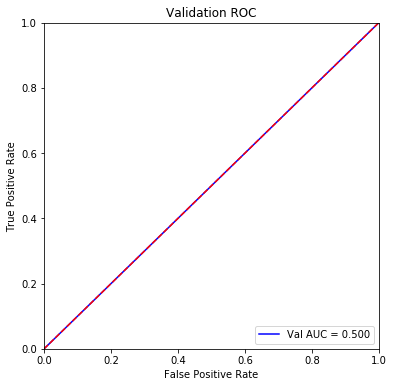

训练集RMSE：1.908
测试集RMSE：1.909
训练集accuracy_score：0.633
测试集accuracy_score：0.635
训练集roc_auc_score：0.500
测试集roc_auc_score：0.500


In [29]:
[dt_train_pre,dt_test_pre] = DecisionTree(dt_best_params,train_x1,train_y1,test_x1,test_y1)

### 2.2随机森林模型

In [30]:
def RandomForest_Grid(X_train,Y_train):
    parameter_space = {
        "n_estimators": range(10,71,5),
        "criterion": ["gini", "entropy"],
        "min_samples_leaf": range(2,10,2)
    }


    rf = RandomForestClassifier(random_state=14)
    # 网格法调参
    grid = GridSearchCV(rf,parameter_space, scoring='accuracy', cv = 5)
    grid.fit(X_train, Y_train)
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Best score set found on development set:")
    print()
    print(grid.best_score_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    return grid.best_params_

def RandomForest(params,X_train,Y_train,X_test,Y_test):
    cri = params['criterion']
    n = params['n_estimators']
    min_s = params['min_samples_leaf']
   
    rf = RandomForestClassifier(n_estimators=n,criterion=cri,min_samples_leaf=min_s,random_state=14)
    rf.fit(X_train, Y_train)
    train_predict = rf.predict(X_train)
    test_predict = rf.predict(X_test)
    
    #画auc曲线
    fpr, tpr, thersholds = metrics.roc_curve(Y_test, test_predict, pos_label=2)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    evaluate1(Y_train, train_predict, Y_test, test_predict) #输出评价指标

    return train_predict,test_predict

In [31]:
rf_best_params = RandomForest_Grid(train_x1,train_y1)

Best parameters set found on development set:

{'criterion': 'gini', 'min_samples_leaf': 8, 'n_estimators': 55}

Best score set found on development set:

0.6330073349633252

Grid scores on development set:

0.629 (+/-0.022) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 10}
0.631 (+/-0.024) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 15}
0.631 (+/-0.025) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 20}
0.631 (+/-0.024) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 25}
0.631 (+/-0.025) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 30}
0.630 (+/-0.023) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 35}
0.632 (+/-0.025) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 40}
0.632 (+/-0.025) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 45}
0.632 (+/-0.025) for {'criterion': 'gini', 'min_samples_leaf': 2, 'n_estimators': 50}
0.632 (+/-0.025) f

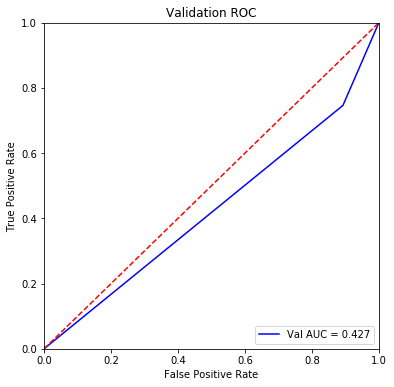

训练集RMSE：1.887
测试集RMSE：1.872
训练集accuracy_score：0.639
测试集accuracy_score：0.644
训练集roc_auc_score：0.455
测试集roc_auc_score：0.427


In [32]:
[rf_train_pre,rf_test_pre] = RandomForest(rf_best_params,train_x1,train_y1,test_x1,test_y1)

## 2.3SVM

#### 数据归一化（MinMaxScaler）

In [33]:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler=MinMaxScaler()
data_x1=train[x1]
minmax_scaler.fit(data_x1)   #进行内部拟合，内部参数会发生变化
scaler_data_x1=minmax_scaler.transform(data_x1)
scaler_train_x1, scaler_test_x1, train_y1, test_y1 = train_test_split(scaler_data_x1,data_y1,test_size=0.3,random_state=0)

In [34]:
def SVM_Grid(X_train,Y_train):
    parameter_space = {
        'C':  list(np.logspace(-3, 3, 7)), 
        'gamma':  list(np.logspace(-3, 3, 7)),
        'kernel':['rbf']
    }


    SVM = SVC(probability=True,random_state=14)
    # 网格法调参
    grid = GridSearchCV(SVM, parameter_space, scoring='accuracy', cv = 5)
    grid.fit(X_train, Y_train)
    print("Best parameters set found on development set:")
    print()
    print(grid.best_params_)
    print()
    print("Best score set found on development set:")
    print()
    print(grid.best_score_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    return grid.best_params_
        
def SVM(params,X_train,Y_train,X_test,Y_test):
    
    C = params['C']
    gamma = params['gamma']
    kernel = params['kernel']
    
    SVM = SVC(C=C,gamma=gamma,kernel=kernel,random_state=14)
    SVM.fit(X_train, Y_train)
    train_predict = SVM.predict(X_train)
    test_predict = SVM.predict(X_test)
    
    #画auc曲线
    fpr, tpr, thersholds = metrics.roc_curve(Y_test, test_predict, pos_label=2)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,6))
    plt.title('Validation ROC')
    plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    evaluate1(Y_train, train_predict, Y_test, test_predict)#输出评价指标

    return train_predict,test_predict

In [35]:
SVM_best_params = SVM_Grid(train_x1,train_y1)

KeyboardInterrupt: 

In [ ]:
[SVM_train_pre,SVM_test_pre] = SVM(SVM_best_params,train_x1,train_y1,test_x1,test_y1)

In [ ]:
scaler_SVM_best_params = SVM_Grid(scaler_train_x1,train_y1) 

In [ ]:
[scaler_SVM_train_pre,scaler_SVM_test_pre] = SVM(scaler_SVM_best_params,scaler_train_x1,train_y1,scaler_test_x1,test_y1)

## 3.有用性预测

In [36]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn import linear_model
import sklearn.model_selection as sk_model_selection
import pandas as pd
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")

In [37]:
#评估函数
def NSE(true, fore):
    fore = fore.reshape(-1)
    true = true.reshape(-1)
    return 1 - np.sum((fore - true) ** 2) / np.sum((true - np.average(true)) ** 2)

def evaluate2(train, train_predict, test, test_predict):
    RMSE_train = mean_squared_error(train, train_predict) ** 0.5
    RMSE_test = mean_squared_error(test, test_predict) ** 0.5

    print('训练集RMSE：%0.3f' % RMSE_train)
    print('测试集RMSE：%0.3f' % RMSE_test)
    
    R2_train = metrics.r2_score(train, train_predict)
    R2_test = metrics.r2_score(test, test_predict)
     
    print('训练集R2：%0.3f' % R2_train)
    print('测试集R2：%0.3f' % R2_test)

    MAE_train = mean_absolute_error(train, train_predict)
    MAE_test = mean_absolute_error(test, test_predict)

    print('训练集MAE：%0.3f' % MAE_train)
    print('测试集MAE：%0.3f' % MAE_test)

    NSE_train = NSE(train, train_predict)
    NSE_test = NSE(test, test_predict)

    print('训练集NSE：%0.3f' % NSE_train)
    print('测试集NSE：%0.3f' % NSE_test)

### 3.1 linear_regression

In [38]:
def linear_regression(X_train,Y_train,X_test,Y_test):
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    # 对测试集进行预测
    train_predict = lr.predict(X_train)
    test_predict = lr.predict(X_test)
   
    evaluate2(Y_train, train_predict, Y_test, test_predict)

    return train_predict, test_predict

In [39]:
linear_regression(train_x2,train_y2,test_x2,test_y2)

训练集RMSE：12.808
测试集RMSE：8.789
训练集R2：0.090
测试集R2：0.153
训练集MAE：3.101
测试集MAE：2.830
训练集NSE：0.090
测试集NSE：0.153


(array([[ 4.07968888],
        [ 0.60976021],
        [14.47798507],
        ...,
        [ 0.64160667],
        [ 0.81543413],
        [ 0.81543413]]), array([[ 0.73614834],
        [20.37226788],
        [ 0.88071367],
        ...,
        [ 0.39232617],
        [ 0.49486191],
        [ 0.81543413]]))

### 3.1 Lasso模型

In [40]:
def Lasso_cross(X_train,Y_train):
    for alpha in np.logspace(-3, 3, 7):  #惩罚系数选取范围可以调整，最终为了找到mse相对较小的惩罚系数
        reg = linear_model.Lasso(alpha=alpha, max_iter=1000)
        # 进行交叉验证
        print(alpha, abs(np.mean(sk_model_selection.cross_val_score(reg,X_train,Y_train, scoring='neg_mean_squared_error', cv = 5)))**0.5)
    return -1

def Lasso(alpha,X_train,Y_train,X_test,Y_test):
    reg = linear_model.Lasso(alpha=alpha, max_iter=1000)
    reg.fit(X_train, Y_train)

    #输出评价指标
    train_predict = reg.predict(X_train)
    test_predict = reg.predict(X_test)
   
    evaluate2(Y_train, train_predict, Y_test, test_predict)

    return train_predict,test_predict

In [41]:
Lasso_cross(train_x2,train_y2)

0.001 12.884095947843822
0.01 12.882062598958067
0.1 12.869077969103566
1.0 12.864940903088197
10.0 12.865068530578272
100.0 12.869579040772082
1000.0 13.232936600976625


-1

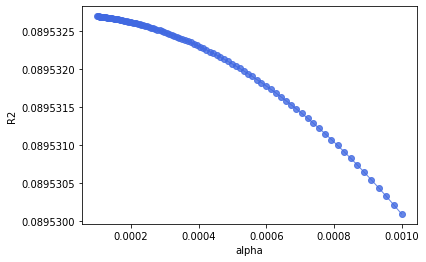

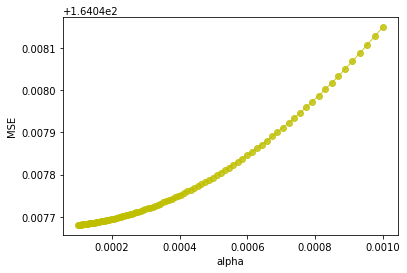

In [42]:
#画图找出更优的惩罚系数
alpha_range = list(np.logspace(-4, -3, 100))
R2 = []
mse = []
for alpha in alpha_range:
    reg = linear_model.Lasso(alpha=alpha, max_iter=1000)
    reg.fit(train_x2,train_y2)
    train_predict = reg.predict(train_x2)

    # 计算R2
    score = metrics.r2_score(train_y2, train_predict)
    score1 = mean_squared_error(train_y2, train_predict)
    R2.append(score)  
    mse.append(score1)
    
plt.plot(alpha_range, R2, 'ro-', color='#4169E1', alpha=0.8, linewidth=1)
plt.xlabel('alpha')
plt.ylabel('R2')

plt.show()

plt.plot(alpha_range, mse, 'ro-', color='y', alpha=0.8, linewidth=1)
plt.xlabel('alpha')
plt.ylabel('MSE')

plt.show()

In [43]:
[L_train_pre,L_test_pre]=Lasso(0.0002,train_x2,train_y2,test_x2,test_y2)

训练集RMSE：12.808
测试集RMSE：8.789
训练集R2：0.090
测试集R2：0.153
训练集MAE：3.101
测试集MAE：2.830
训练集NSE：0.090
测试集NSE：0.153


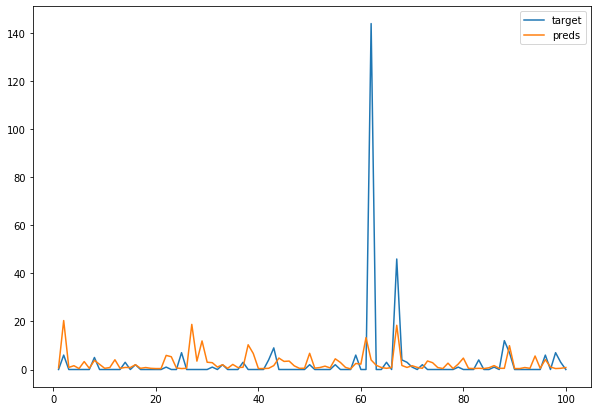

In [44]:
#绘图进行比较
plt.figure(figsize=(10,7))       #画布大小
num=100
x=np.arange(1,num+1)             
plt.plot(x,test_y2[:num],label='target')      #目标取值
plt.plot(x,L_test_pre[:num],label='preds')        #预测取值
plt.legend(loc='upper right')  #图例显示位置
plt.show()

### 3.3 Ridge模型

In [45]:
def Ridge_cross(X_train,Y_train):
    for alpha in np.logspace(0, 6, 7):   #惩罚系数选取范围可以调整，最终为了找到mse相对较小的惩罚系数
        reg = linear_model.Ridge(alpha=alpha, max_iter=10000)
        # 进行交叉验证
        print(alpha, abs(np.mean(sk_model_selection.cross_val_score(reg, X_train, Y_train, scoring='neg_mean_squared_error', cv = 5)))**0.5)

def Ridge(alpha,X_train,Y_train,X_test,Y_test):
    reg = linear_model.Ridge(alpha=alpha, max_iter=10000)
    reg.fit(X_train, Y_train)

    #输出评价指标
    train_predict = reg.predict(X_train)
    test_predict = reg.predict(X_test)

    evaluate2(Y_train, train_predict, Y_test, test_predict)

    return train_predict, test_predict

In [46]:
Ridge_cross(train_x2,train_y2)

1.0 12.884235012368022
10.0 12.882640737915072
100.0 12.875656922859172
1000.0 12.866821260468617
10000.0 12.865092413204536
100000.0 12.864935110757816
1000000.0 12.864829163970178


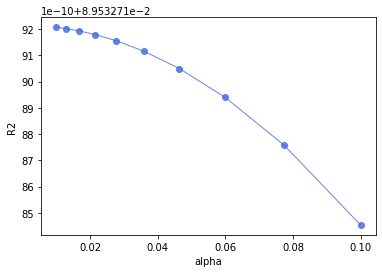

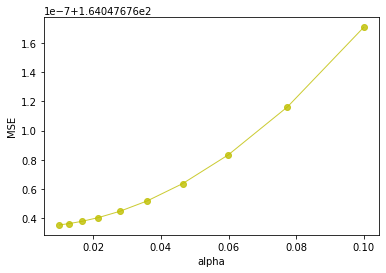

In [47]:
#画图找出更优的惩罚系数
alpha_range = list(np.logspace(-2, -1, 10))
R2 = []
mse = []
for alpha in alpha_range:
    reg = linear_model.Ridge(alpha=alpha, max_iter=1000)
    reg.fit(train_x2,train_y2)
    train_predict = reg.predict(train_x2)

    # 计算R2
    score = metrics.r2_score(train_y2, train_predict)
    score1 = mean_squared_error(train_y2, train_predict)
    R2.append(score)  
    mse.append(score1)

plt.plot(alpha_range, R2, 'ro-', color='#4169E1', alpha=0.8, linewidth=1)
plt.xlabel('alpha')
plt.ylabel('R2')

plt.show()

plt.plot(alpha_range, mse, 'ro-', color='y', alpha=0.8, linewidth=1)
plt.xlabel('alpha')
plt.ylabel('MSE')

plt.show()

In [48]:
[R_train_pre,R_test_pre] = Ridge(0.002,train_x2,train_y2,test_x2,test_y2)

训练集RMSE：12.808
测试集RMSE：8.789
训练集R2：0.090
测试集R2：0.153
训练集MAE：3.101
测试集MAE：2.830
训练集NSE：0.090
测试集NSE：0.153


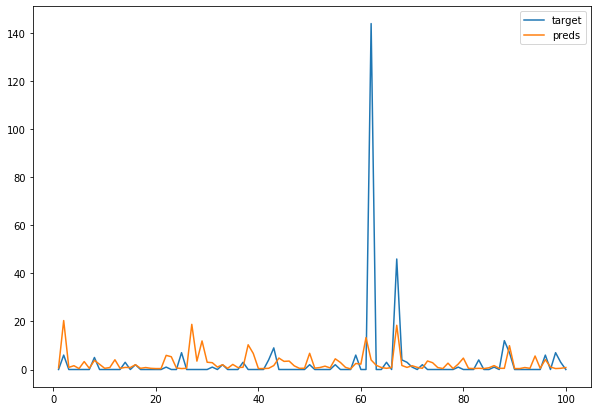

In [49]:
#绘图进行比较
plt.figure(figsize=(10,7))       #画布大小
num=100
x=np.arange(1,num+1)             
plt.plot(x,test_y2[:num],label='target')      #目标取值
plt.plot(x,R_test_pre[:num],label='preds')        #预测取值
plt.legend(loc='upper right')  #图例显示位置
plt.show()

### 有用性预测2

In [50]:
if_helpful = []
for i in train['helpful_votes'].tolist():
    if i >0:
        if_helpful.append(1) 
    else:
        if_helpful.append(0)
train['if_helpful'] = if_helpful

In [51]:
#有用性预测（helpful votes):image,review_len,各个feature得分
data_x2=train[x2]
data_y2=train[['if_helpful']]
data_x2 = data_x2.as_matrix()
data_y2 = data_y2.as_matrix()
train_x2, test_x2, train_y2, test_y2 = train_test_split(data_x2,data_y2,test_size=0.3,random_state=0)

In [52]:
dt_best_params2 = DecisionTree_Grid(train_x2,train_y2)

Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 4}

Best score set found on development set:

0.7300733496332519

Grid scores on development set:

0.716 (+/-0.018) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 2}
0.716 (+/-0.018) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 4}
0.716 (+/-0.018) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 6}
0.716 (+/-0.018) for {'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 8}
0.726 (+/-0.011) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2}
0.728 (+/-0.012) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 4}
0.726 (+/-0.010) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 6}
0.724 (+/-0.008) for {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 8}
0.708 (+/-0.019) for {'criterion': 'gini', 'max_depth': 11, 'min_samples_leaf': 2}
0.713 (+/-0.023) for {'criterion': 'gini', 'max_depth'

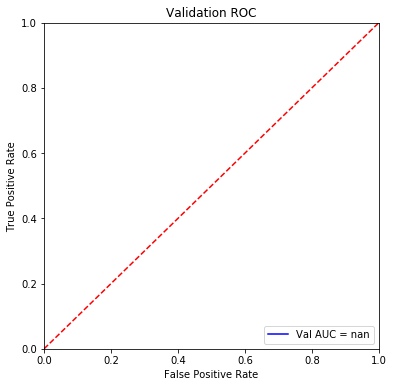

训练集RMSE：0.500
测试集RMSE：0.515
训练集accuracy_score：0.750
测试集accuracy_score：0.735
训练集roc_auc_score：nan
测试集roc_auc_score：nan


In [53]:
[dt_train_pre2,dt_test_pre2] = DecisionTree(dt_best_params2,train_x2,train_y2,test_x2,test_y2)

In [ ]:
rf_best_params2 = RandomForest_Grid(train_x2,train_y2)

In [ ]:
[rf_train_pre2,rf_test_pre2] = RandomForest(rf_best_params2,train_x2,train_y2,test_x2,test_y2)

In [63]:
SVM_best_params2 = SVM_Grid(train_x2,train_y2)

Best parameters set found on development set:

{'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}

Best score set found on development set:

0.5145728643216081

Grid scores on development set:

0.515 (+/-0.072) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.001, 'gamma': 0.1, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.001, 'gamma': 1.0, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.001, 'gamma': 10.0, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.001, 'gamma': 100.0, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.001, 'gamma': 1000.0, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.515 (+/-0.072) for {'

In [ ]:
[SVM_train_pre2,SVM_test_pre2] = SVM(SVM_best_params2,train_x2,train_y2,test_x2,test_y2)